# Services shortage

This example provides a pipeline to assess territory's shortage in **services**. 

P.S: It is considered that the `blocks` are already aggregated with services and the population.

In [1]:
import geopandas as gpd

blocks = gpd.read_parquet('blocks.parquet')

In [2]:
import pandas as pd

acc_mx = pd.read_pickle('./../data/accessibility_matrix.pickle')

In [3]:
block_id = 1536

In [4]:
orientations = {
    'Традиционные ценности': {
        'Крепкая семья': [],
        'Дети': ['kindergarten', 'playground', 'school'],
        'Патриотизм': ['museum'],
        'Историческая память и преемственность поколений': ['school', 'university', 'cemetery'],
    },
    'Ценности свободы': {
        'Внешняя мобильность': ['aeroway_terminal', 'train_station', 'train_building', 'bus_station'],
        'Локальная мобильность': ['subway_entrance', 'bus_stop', 'bus_station', 'fuel'],
        'Досуг': ['swimming_pool', 'stadium', 'zoo', 'cafe', 'cinema'],
        'Туризм': ['guest_house', 'hotel', 'hostel', 'museum', 'park'],
    },
    'Духовные ценности': {
        'Духовность (религия)': ['religion'],
        'Образование и наука': ['school', 'university'],
        'Культура': ['library', 'theatre', 'museum'],
        'Творчество': [],
        'Забота о питомцах': ['dog_park', 'veterinary'],
    },
    'Материальные ценности': {
        'Безопасность': ['police', 'lawyer'],
        'Здоровье': ['pharmacy', 'polyclinic', 'hospital', 'pitch'],
        'Потребление (гедонизм)': ['convenience', 'supermarket', 'market', 'bakery', 'cafe', 'mall', 'bar', 'houseware', 'post', 'multifunctional_center'],
        'Карьера и материальный достаток': ['recruitment', 'university', 'bank'],
        'Экология': [],
    }
}

In [5]:
from blocksnet.config import service_types_config

service_types = set([st for _,values in orientations.items() for _,service_types in values.items() for st in service_types])
assert all([st in service_types_config for st in service_types]), 'wrong naming i guess'
len(service_types)

44

## Actual code

Two cases will be considered:

- Assess the shortage for the selected territory as is.

- The selected territory is redeveloped from the ground up.

In [6]:
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

In [7]:
import pandas as pd
import geopandas as gpd
from blocksnet.analysis.provision import competitive_provision
from blocksnet.relations.accessibility import get_accessibility_context

def assess_provision(blocks : gpd.GeoDataFrame, project_blocks : list[int], acc_mx : pd.DataFrame, service_type : str, ground_up : bool = False):
    _, demand, accessibility = service_types_config[service_type].values()
    provision_blocks = blocks[['population', f'capacity_{service_type}']].rename(columns={f'capacity_{service_type}': 'capacity'}).copy()
    if ground_up:
        provision_blocks.loc[project_blocks] = 0

    provision, _ = competitive_provision(provision_blocks, acc_mx, demand, accessibility)  
    
    context_mx = get_accessibility_context(acc_mx, provision_blocks.loc[project_blocks], accessibility, out=False, keep=True)
    context_provision_df = provision.loc[context_mx.index]
    # shortage = context_provision_df['demand_left'].sum()

    return context_provision_df

Ground up

In [8]:
from tqdm import tqdm

provisions = {}

for service_type in tqdm(service_types):
    column = f'capacity_{service_type}'
    if column in blocks.columns:
        shortage = assess_provision(blocks, [block_id], acc_mx, service_type, True)
        provisions[service_type] = shortage

 18%|█▊        | 8/44 [01:53<09:10, 15.30s/it]/home/vasilstar/masterplanning/blocksnet/analysis/provision/competivive/core.py:75: RuntimeWarning: overflow encountered in scalar power
  return demand_blocks.loc[id1, DEMAND_LEFT_COLUMN] / (distance**2)
 20%|██        | 9/44 [04:26<34:06, 58.47s/it]/home/vasilstar/masterplanning/blocksnet/analysis/provision/competivive/core.py:75: RuntimeWarning: overflow encountered in scalar power
  return demand_blocks.loc[id1, DEMAND_LEFT_COLUMN] / (distance**2)
 39%|███▊      | 17/44 [07:07<06:05, 13.54s/it]/home/vasilstar/masterplanning/blocksnet/analysis/provision/competivive/core.py:75: RuntimeWarning: overflow encountered in scalar power
  return demand_blocks.loc[id1, DEMAND_LEFT_COLUMN] / (distance**2)
 70%|███████   | 31/44 [10:31<01:51,  8.61s/it]/home/vasilstar/masterplanning/blocksnet/analysis/provision/competivive/core.py:75: RuntimeWarning: overflow encountered in scalar power
  return demand_blocks.loc[id1, DEMAND_LEFT_COLUMN] / (distanc

In [21]:
from blocksnet.analysis.provision import provision_strong_total

def assess_shortage(provision_df : pd.DataFrame):
    return provision_df['demand_left'].sum()

stats = {}

for st,prov in provisions.items():
    demand_left = prov['demand_left'].sum()
    provision_strong = provision_strong_total(prov)
    stats[st] = {'shortage': demand_left, 'total': provision_strong}

In [25]:
stats_df = pd.DataFrame.from_dict(stats, orient='index')
stats_df.sort_values('shortage', ascending=False).head()

,shortage,total
bus_station,270638,0.001292
zoo,269651,0.004934
museum,262237,0.032293
train_building,261347,0.035577
hostel,260337,0.039304


In [62]:
values_totals = {}

for _,values in orientations.items():
    for value,sts in values.items():
        sts = [st for st in sts if st in stats_df.index]
        total = stats_df.loc[sts]['total'].mean()
        values_totals[value] = round(total,2)

values_totals_df = pd.DataFrame.from_dict(values_totals, orient='index', columns=['total'])

<Axes: >

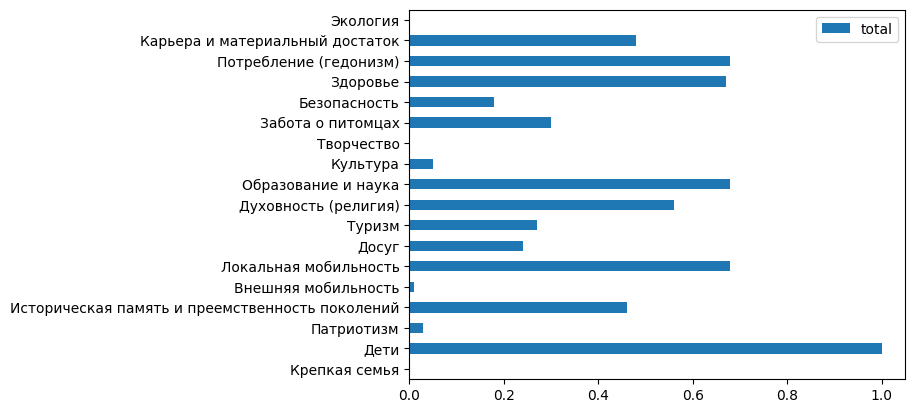

In [61]:
values_totals_df.plot.barh(y='total')